<a href="https://colab.research.google.com/github/EgorMatveev26/Datasets/blob/main/%D0%9B%D0%A0_%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F_2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Для данных
import pandas as pd
import numpy as np
## Для графиков
import matplotlib.pyplot as plt
import seaborn as sns
## Для тестов
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
## Для машинного обучения
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Загружаем данные в датафрейм
df = pd.read_csv('insurance.csv', delimiter=',')

In [ ]:
# Выводим первые 10 строк
df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [ ]:
# Выводим информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
# Определяем, является ли столбец числовым или категориальным
# Функция принимает следующие параметры:
# df: dataframe - входные данные
# col:str - имя столбца для анализа
# max_cat: num — максимальное количество уникальных значений для распознавания столбца как категориального
def utils_recognize_type(df, col, max_cat=20):
    if (df[col].dtype == "O") | (df[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"

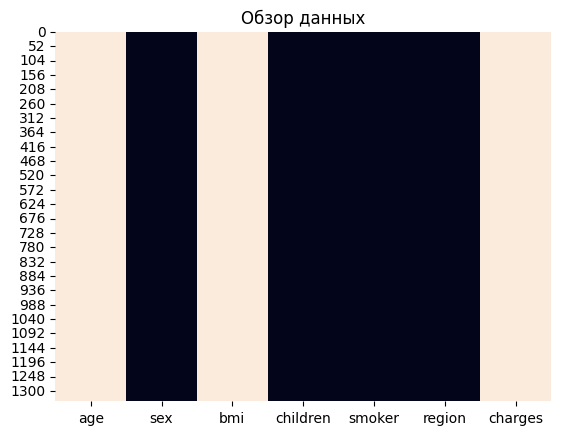

 Categerocial   Numeric   NaN 


In [ ]:
# Формируем словарь dic_cols
# Ключи - название столбцов
# Значение - категориальный (cat) или числовой (num)

dic_cols = {col:utils_recognize_type(df, col, max_cat=20) for col in df.columns}

# Функция df.isnull() - возвращает датасет, который похож на изначальный датасет df, но в каждой ячейке вместо значений написано:
# False (если значение есть)
# True  (если в ячейке отсутствует значение)

heatmap = df.isnull()

# Дальше проходим по столбцам, и меняем значения
for k,v in dic_cols.items():
    # Если столбец числовой
    if v == "num":
        # пишем 0.5, если значение False (то есть оно не нулевое)
        # пишем 1,   если значение True
        heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
    # Если столбец категориальный
    else:
        # пишем 0, если значение False   (то есть оно не нулевое)
        # пишем 1,   если значение True
        heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)

# Строим тепловую карту
# 0.5 - если значение есть и оно числовое
# 0   - если значение есть и оно категориальное
# 1   - если значения в ячейке нет
sns.heatmap(heatmap, cbar=False).set_title('Обзор данных')
plt.show()

# Печатаем внизу подобие легенды, раскрашивая так, как нужно
print("\033[1;37;40m Categerocial ", "\033[38;5;0;48;5;180m Numeric ", "\033[1;30;47m NaN ")

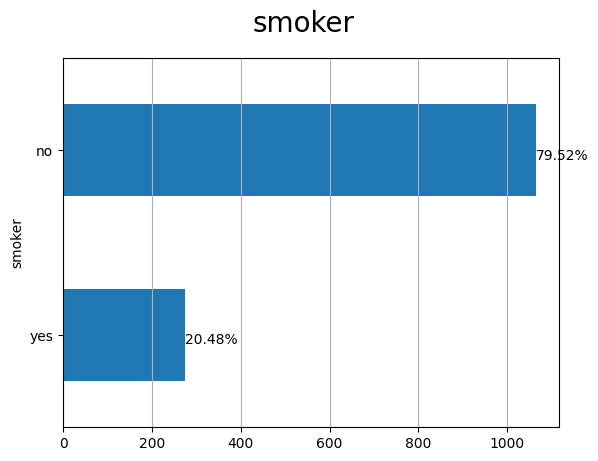

In [ ]:
# Анализируем, какое количество человек курит(smoker), то есть мы группируем все объекты по их целевой переменной (smoker) и просто считаем, сколько объектов попало в каждую группу
y ="smoker"

# Далее считаем количество объектов с одинаковыми значениями в столбце y и сортируем их
ax = df[y].value_counts().sort_values().plot(kind="barh")

# Затем формируем надписи для графика
totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.20,
            str(round((i.get_width()/total)*100, 2))+'%',
            fontsize=10, color='black')
ax.grid(axis="x")
plt.suptitle(y, fontsize=20)
plt.show()

Из графика видим, что примерно 20% людей курят, а 80% людей не имеют такой привычки.

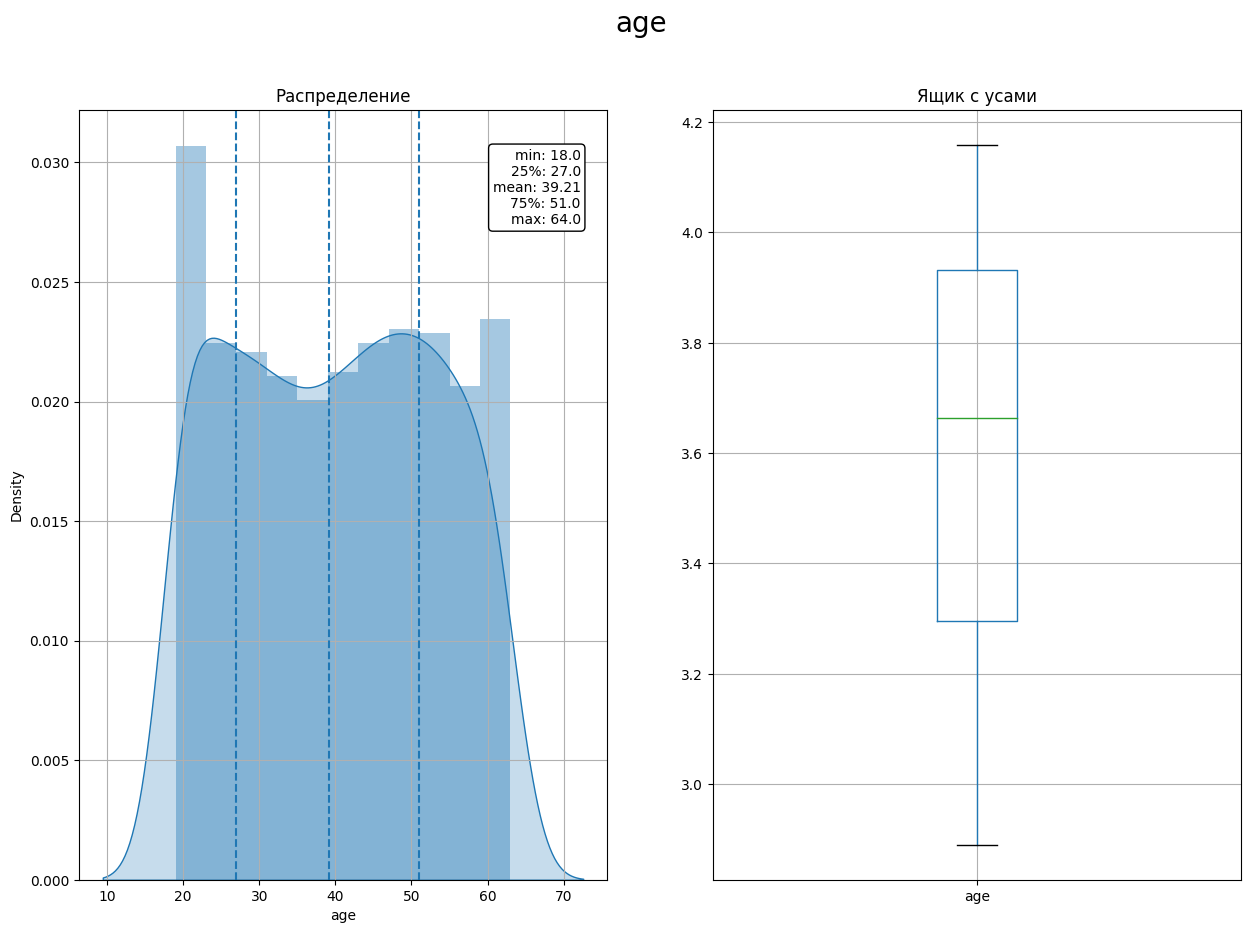

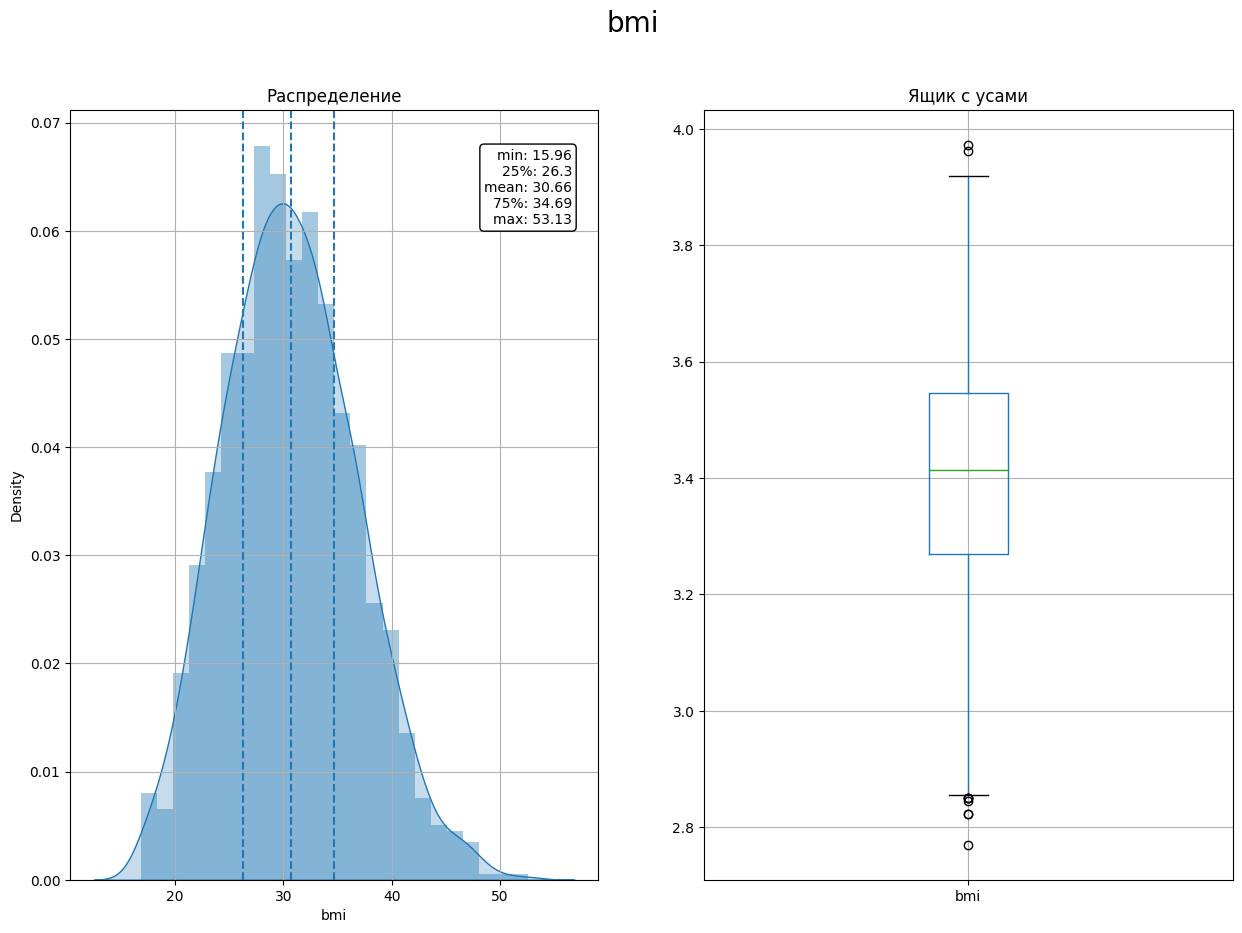

In [ ]:
# Функция для вывода распределение столбца
def show_dist(x, df):
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(15, 10))
    fig.suptitle(x, fontsize=20)

    ### Распределение
    ax[0].title.set_text('Распределение') # Название
    variable = df[x].fillna(df[x].mean()) # Замена отсутствующих значений в датафрейме на средние
    breaks = np.quantile(variable, q=np.linspace(0, 1, 11)) # Вычисляем q-й квантиль заданных данных вдоль указанной оси
    variable = variable[(variable > breaks[0]) & (variable < breaks[10])]
    sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0]) # Создаём гистограмму
    des = df[x].describe()

    # Добавляем на график квантили
    ax[0].axvline(des["25%"], ls='--')
    ax[0].axvline(des["mean"], ls='--')
    ax[0].axvline(des["75%"], ls='--')
    ax[0].grid(True)
    des = round(des, 2).apply(lambda x: str(x))
    box = '\n'.join(("min: " + des["min"], "25%: " + des["25%"], "mean: " + des["mean"], "75%: " + des["75%"], "max: " + des["max"]))
    ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right",
               bbox=dict(boxstyle='round', facecolor='white', alpha=1))

    ### Ящик с усами
    ax[1].title.set_text('Ящик с усами')
    tmp_dtf = pd.DataFrame(df[x])
    tmp_dtf[x] = np.log(tmp_dtf[x])
    tmp_dtf.boxplot(column=x, ax=ax[1])

    plt.show()

# Посмотрим на распределение возраста пациентов и их индекса массы тела
show_dist('age', df)
show_dist('bmi', df)

1. Возрастная группа имеет равномерное распределение, с наиболее частыми возрастами около 20 и 60 лет. Средний возраст составляет примерно 39 лет, а основная масса данных сосредоточена в диапазоне от 27 до 51 года.

2. Средний ИМТ находится в районе 30.
Существуют выбросы на верхнем конце, что указывает на наличие людей с более высоким ИМТ.
Большинство значений ИМТ сгруппировано в диапазоне от 26 до 34.

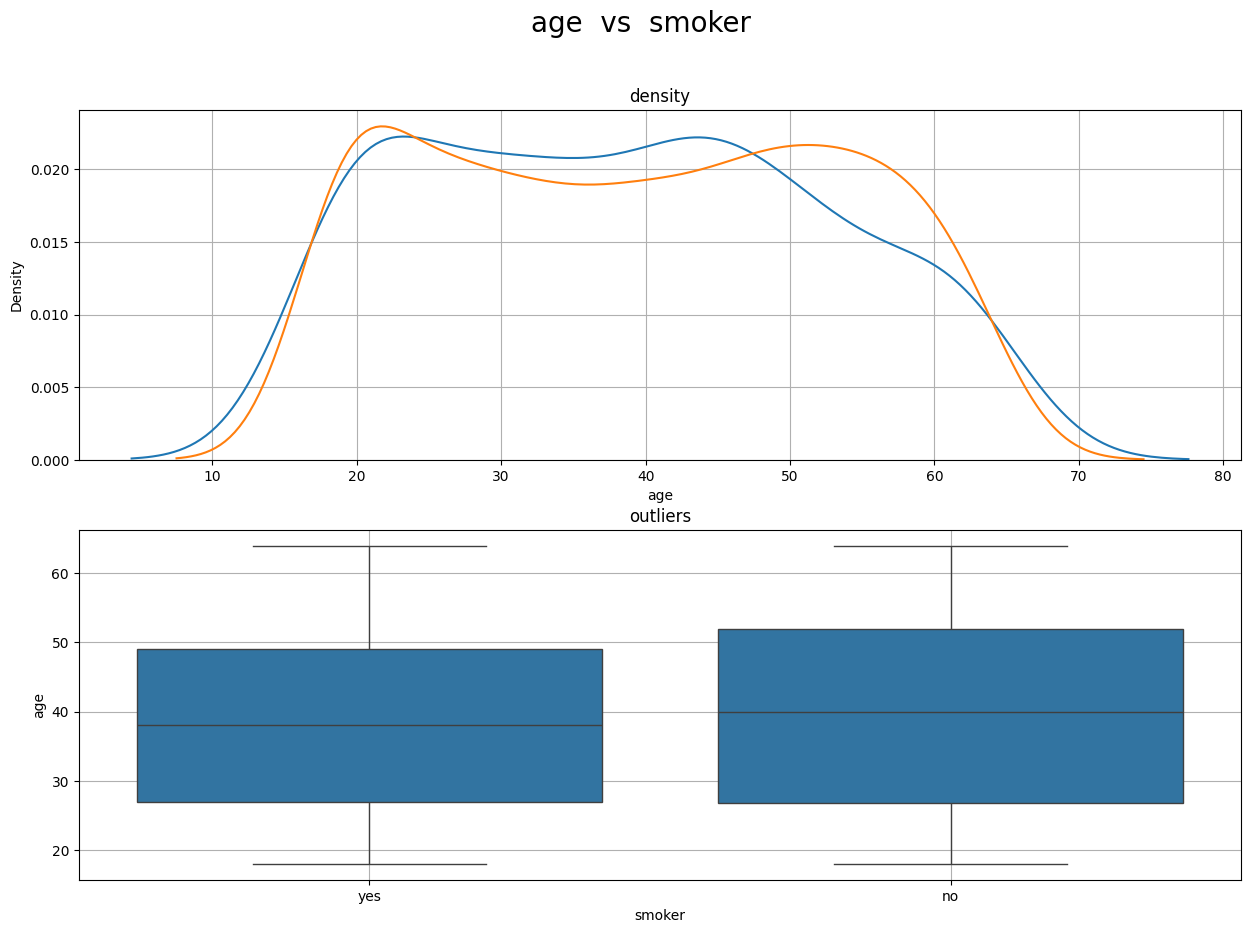

In [ ]:
# Построим графики распределения переменной x для каждого класса целевой переменной
x = "age"
fig, ax = plt.subplots(nrows=2, ncols=1,  sharex=False, sharey=False, figsize=(15, 10)) # Распаковываем  кортеж в переменные fig и ax.
# Получаем объект рисунка и массив подграфиков, где первое число - количество строк, второе - столбцов, sharex, sharey задают нужно ли разделять ось между подграфиками
fig.suptitle(x + "  vs  " + y, fontsize=20) # Название

### Распределение
ax[0].title.set_text('density')
for i in df[y].unique():  # Перебираем все уникальные значения в столбце y, y = "Churn"
    sns.kdeplot(df[df[y]==i][x], label=i, ax=ax[0]) # Построим график плотности распределения столбца x, при условии, что значение в столбце y совпадет с i
ax[0].grid(True) # Настроим линии сетки.

### Ящик с усами
ax[1].title.set_text('outliers') # Устанавливаем заголовок
sns.boxplot(x=y, y=x, data=df, ax=ax[1]) # Нарисуем блочную диаграмму, чтобы показать распределения по категориям.


ax[1].grid(True) # Настроим линии сетки.

plt.show()

На графике плотности видно, что распределение для обеих групп схоже, однако у курящих пик плотности приходится на немного более ранний возраст по сравнению с некурящими.

У курящих и некурящих схожие медианные значения возраста.
Размах данных для курящих и некурящих также похож, хотя у некурящих есть небольшие выбросы в обе стороны.

In [ ]:
# Функция для преобразования датасета
def prep(df):
    # Удаляем пропуски
    df = df.replace(' ', np.NaN)
    df = df.dropna()
    # Заменяем бинарные переменные на 0 и 1
    df = df.replace('female', 0).replace('male', 1).replace('no', 0).replace('yes', 1)
    # Заменяем категориальные переменные
    df["region"] = df["region"].astype('category')
    df["region_ind"] = df["region"].cat.codes
    return  df

In [ ]:
# Разделяем выборку на обучающую и тестовую (30%)
dtf_tr, dtf_t = model_selection.train_test_split(df, test_size=0.3)

# Подготавливаем данные в трейне и тесте
dtf_train = prep(dtf_tr)
dtf_test = prep(dtf_t)

# Выводим информацию о выборках
print("X_train shape:", dtf_train.drop("smoker",axis=1).shape, "| X_test shape:", dtf_test.drop("smoker",axis=1).shape)
print("y_train mean:", round(np.mean(dtf_train["smoker"]),2), "| y_test mean:", round(np.mean(dtf_test["smoker"]),2))
print(dtf_train.drop("smoker",axis=1).shape[1], "columns:", dtf_train.drop("smoker",axis=1).columns.to_list())

X_train shape: (936, 7) | X_test shape: (402, 7)
y_train mean: 0.22 | y_test mean: 0.18
7 columns: ['age', 'sex', 'bmi', 'children', 'region', 'charges', 'region_ind']


In [ ]:
# Смотрим размер полученной выборки в трейне: 936 строк, 8 столбцов
dtf_train.shape

(936, 8)

In [ ]:
# Для обучающей выборки берём нужные столбцы и целевую переменную
train_x = dtf_train[['age', 'sex', 'bmi', 'children', 'region_ind', 'charges']]
train_y = dtf_train['smoker']

In [ ]:
# Тоже самое делаем для тестовой выборки
test_x = dtf_test[['age', 'sex', 'bmi', 'children', 'region_ind', 'charges']]
test_y = dtf_test['smoker']

In [ ]:
# Целевая переменная
Y = 'smoker'
# Нормализуем данные так, чтобы все значения находились в диапазоне от 0 до 1
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(train_x)

# Нормализованные значения обучающей выборки
train_x_scaled = pd.DataFrame(X, columns=train_x.columns,index=train_x.index )
train_y_scaled = train_y

train_x_scaled.head() # Смотрим, как прошла нормализация

,age,sex,bmi,children,region_ind,charges
811,0.326087,0.0,0.725854,0.6,0.333333,0.085229
38,0.369565,1.0,0.557170,0.2,0.000000,0.628791
666,0.673913,1.0,0.342750,0.2,1.000000,0.123336
434,0.282609,1.0,0.339925,0.2,0.333333,0.050784
1086,0.804348,1.0,0.350148,0.0,0.000000,0.157383


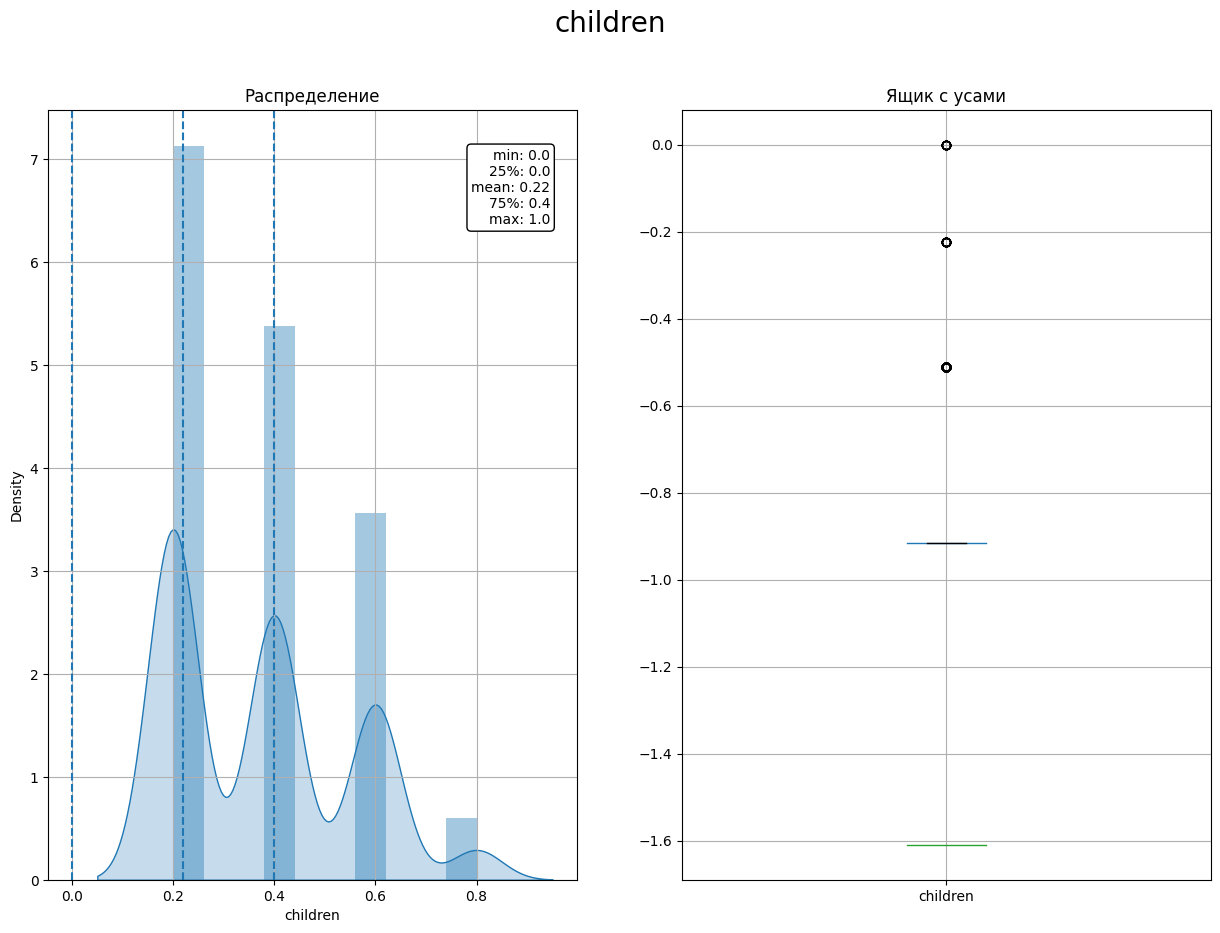

In [ ]:
# Нарисуем графики для переменной "кол-во детей у пациента" по обучающему датасету
show_dist('children', train_x_scaled)

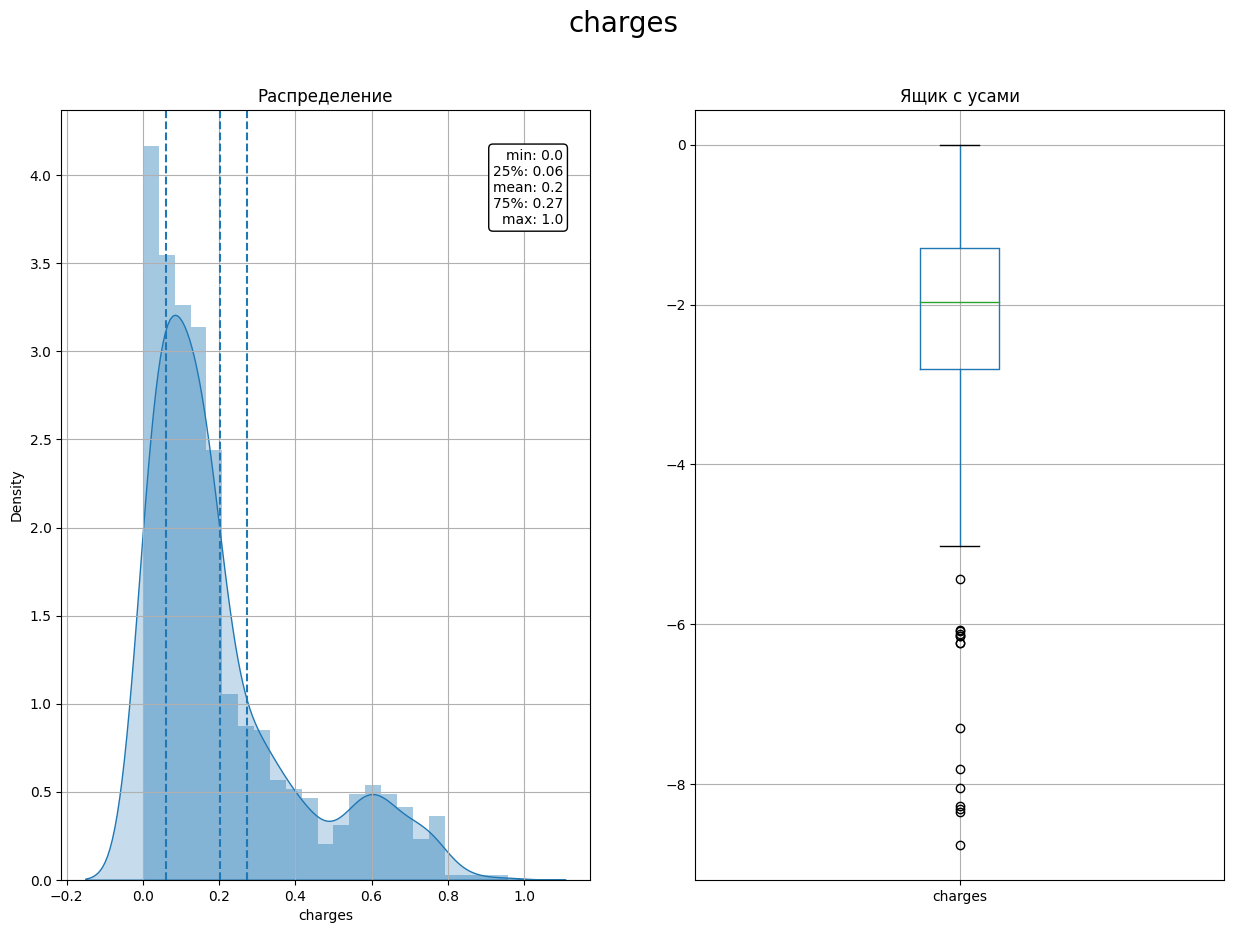

In [ ]:
show_dist('charges', train_x_scaled) # Нарисуем график для переменной "суммарные медицинские расходы"

In [ ]:
# Выведем результат нормализации
X

array([[0.32608696, 0.        , 0.72585418, 0.6       , 0.33333333,
        0.08522913],
       [0.36956522, 1.        , 0.55716976, 0.2       , 0.        ,
        0.62879086],
       [0.67391304, 1.        , 0.34274953, 0.2       , 1.        ,
        0.12333592],
       ...,
       [0.60869565, 0.        , 0.34813021, 0.4       , 1.        ,
        0.12528518],
       [1.        , 0.        , 0.4574926 , 0.        , 0.33333333,
        0.22076745],
       [0.19565217, 1.        , 0.35485607, 0.        , 0.66666667,
        0.2785805 ]])

In [ ]:
# Выведем индексы обучающей выборки
train_x.index

Index([ 811,   38,  666,  434, 1086,  419,   91,  786,   98,  708,
       ...
        269,  152,  674, 1156,  842, 1164,  128,  178,  402,  741],
      dtype='int64', length=936)

In [ ]:
# Нормализуем тестовую выборку
X = scaler.fit_transform(test_x)

test_x_scaled = pd.DataFrame(X, columns=test_x.columns,index=test_x.index)
test_y_scaled = test_y

Text(0.5, 1.0, 'Корреляция Пирсона')

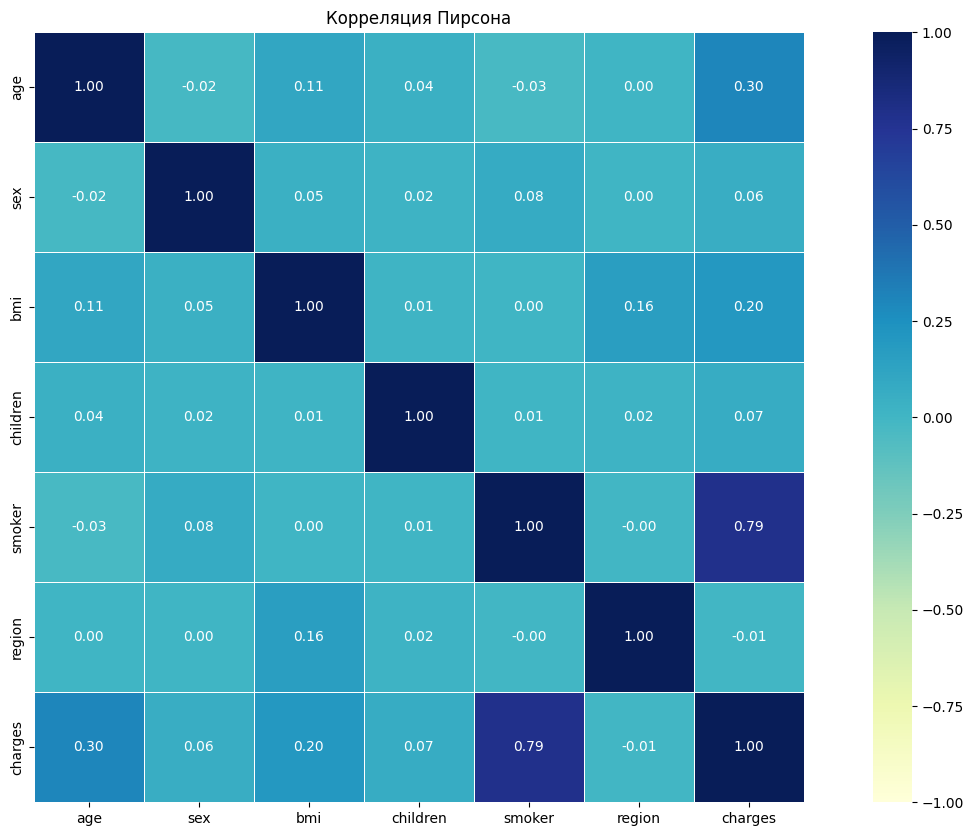

In [ ]:
# Вычисляем матрицу корреляций
corr_matrix = df.copy()
plt.figure(figsize=(18,10),dpi=100)

for col in corr_matrix.columns: # Зададим условия для столбцов object
  if corr_matrix[col].dtype == "O":
      corr_matrix[col] = corr_matrix[col].factorize(sort=True)[0]
corr_matrix = corr_matrix.corr(method="pearson",numeric_only = True)
# Визуализируем матрицу корреляции
sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5, square=True)
plt.title("Корреляция Пирсона")

Smoker и Charges (r = 0.79):
Наблюдается сильная положительная корреляция, а это
указывает на то, что курильщики тратят большие суммы на своё здоровье. Age и Charges (r = 0.30):
Умеренная положительная корреляция показывает, что с возрастом медицинские расходы увеличиваются.

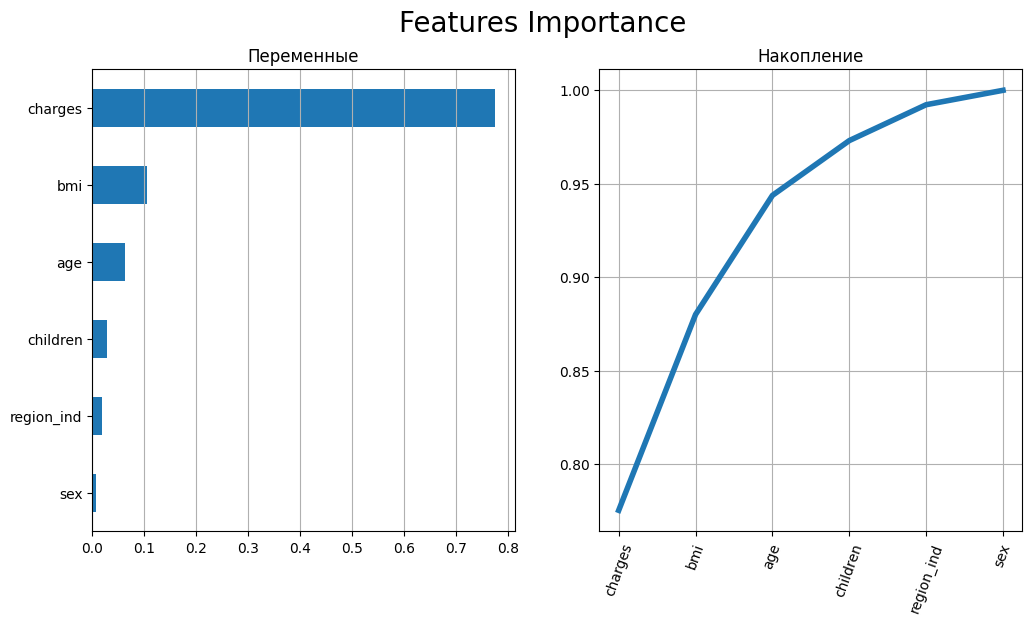

In [ ]:
# Оценим важность каждого столбца
X = train_x_scaled.values
y = train_y_scaled.values
feature_names = train_x_scaled.columns.tolist() # Имена столбцов в датасете.
# Важность параметров
model = ensemble.RandomForestClassifier(n_estimators=100,
                                        criterion="entropy", random_state=0)
model.fit(X,y)
importances = model.feature_importances_ # Это оценка, присваиваемая функциям модели машинного обучения,которая определяет, насколько «важной» является функция для прогноза модели
# Создаём датафрейм
dtf_importances = pd.DataFrame({"IMPORTANCE":importances,
                                "VARIABLE":feature_names}).sort_values("IMPORTANCE",
                                                                       ascending=False)
dtf_importances['cumsum'] = dtf_importances['IMPORTANCE'].cumsum(axis=0)
dtf_importances = dtf_importances.set_index("VARIABLE")


# Графики
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False,figsize=(12,6),dpi=100) # Распаковываем  кортеж в переменные fig и ax.
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('Переменные') # Подпишем график
dtf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(
    kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('Накопление') # Подпишем график
dtf_importances[["cumsum"]].plot(kind="line", linewidth=4,
                                 legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(dtf_importances)),
          xticklabels=dtf_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both') # Настроим сетку.

plt.show()

In [ ]:
# Выбираем для модели наиболее значимые признаки
X_train = train_x_scaled[['age', 'bmi', 'charges']]
y_train = train_y_scaled

X_test = test_x_scaled[['age', 'bmi', 'charges']]
y_test = test_y_scaled

In [ ]:
'''
Будем использовать GradientBoostingClassifier - градиентный бустинг.
Он строит предсказание в виде ансамбля слабых предсказывающих моделей, которыми в основном являются деревья решений.
Из нескольких слабых моделей в итоге мы собираем одну, но уже эффективную.
Общая идея алгоритма – последовательное применение предиктора (предсказателя) таким образом, что каждая последующая модель сводит ошибку предыдущей к минимуму.
Оценивать качество предсказаний будем по RandomizedSearchCV
'''

model = ensemble.GradientBoostingClassifier()
param_dic = {'learning_rate':[0.15,0.1,0.05],     #весовой коэффициент для поправок по новым деревьям при добавлении в модель
             'n_estimators':[100,250,500],  #количество деревьев, добавленных в модель
             'max_depth':[2,3,4,5],    #максимальная глубина дерева
             'min_samples_split':[2,4,6],    #задает минимальное количество выборок для разделения
             'min_samples_leaf':[1,3,5],     #минимальное количество выборок для формирования листа
             'max_features':[2,3,4],     #квадратный корень из функций обычно является хорошей отправной точкой
             'subsample':[0.7,0.8,0.9,1]}       #образцы, которые будут использоваться для подгонки индивидуального базового файла
## random search(Рандомизированный поиск по гиперпараметрам)
random_search = model_selection.RandomizedSearchCV(model,
                                                   param_distributions=param_dic, n_iter=10,
                                                   scoring="accuracy").fit(X_train, y_train)
print("Best Model parameters:", random_search.best_params_)
print("Best Model mean accuracy:", random_search.best_score_)
model = random_search.best_estimator_   # здесь теперь хранятся параметры, при которых были получены наилучшие метрики на трейне

Best Model parameters: {'subsample': 1, 'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 2, 'max_depth': 5, 'learning_rate': 0.1}
Best Model mean accuracy: 0.9561952440550687


In [ ]:
# Обучаем модель
model.fit(X_train, y_train)
# Выполняем прогнозирование на тестовой выборке
predicted_prob = model.predict_proba(X_test)
predicted = model.predict(X_test).astype('int32')

In [ ]:
# Вероятность отнесения значения к каждому из классов
predicted_prob

array([[1.00000000e+00, 2.97736751e-12],
       [1.00000000e+00, 1.43847258e-12],
       [4.39638993e-07, 9.99999560e-01],
       [1.00000000e+00, 7.83546860e-12],
       [8.15294499e-10, 9.99999999e-01],
       [9.99999990e-01, 9.79587519e-09],
       [1.00000000e+00, 1.16142308e-13],
       [1.00000000e+00, 1.46662271e-12],
       [9.85779463e-08, 9.99999901e-01],
       [1.00000000e+00, 1.47914568e-12],
       [9.99999995e-01, 4.57456984e-09],
       [9.99997239e-01, 2.76109917e-06],
       [2.74809410e-07, 9.99999725e-01],
       [9.99999990e-01, 9.56026364e-09],
       [1.00000000e+00, 2.26385521e-13],
       [2.25226505e-08, 9.99999977e-01],
       [1.68915225e-08, 9.99999983e-01],
       [1.00000000e+00, 1.43812880e-12],
       [1.00000000e+00, 7.27378109e-12],
       [1.00000000e+00, 1.51656841e-13],
       [9.99999999e-01, 6.55840655e-10],
       [1.00000000e+00, 4.52641296e-12],
       [1.00000000e+00, 4.49523004e-10],
       [1.00000000e+00, 1.43346094e-10],
       [1.000000

In [ ]:
# Реальные значения классов
y_test.astype('int32')

,smoker
1219,0
179,0
203,1
1182,0
852,1
...,...
909,1
230,0
475,1
148,0


In [ ]:
# Оценим точность классификации и производительность модели
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted,  multi_class='ovo',average= "weighted")

print("Accuracy (overall correct predictions):",  round(accuracy,2))
print("Auc:", round(auc,2))

# Выведем характеристики модели
recall = metrics.recall_score(y_test, predicted, average="weighted")
precision = metrics.precision_score(y_test, predicted, average="weighted")
print("Recall (all 1s predicted right):", round(recall,2))
print("Precision (confidence when predicting a 1):", round(precision,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted, target_names=[str(i) for i in np.unique(y_test)]))

Accuracy (overall correct predictions): 0.97
Auc: 0.95
Recall (all 1s predicted right): 0.97
Precision (confidence when predicting a 1): 0.97
Detail:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       331
           1       0.92      0.92      0.92        71

    accuracy                           0.97       402
   macro avg       0.95      0.95      0.95       402
weighted avg       0.97      0.97      0.97       402



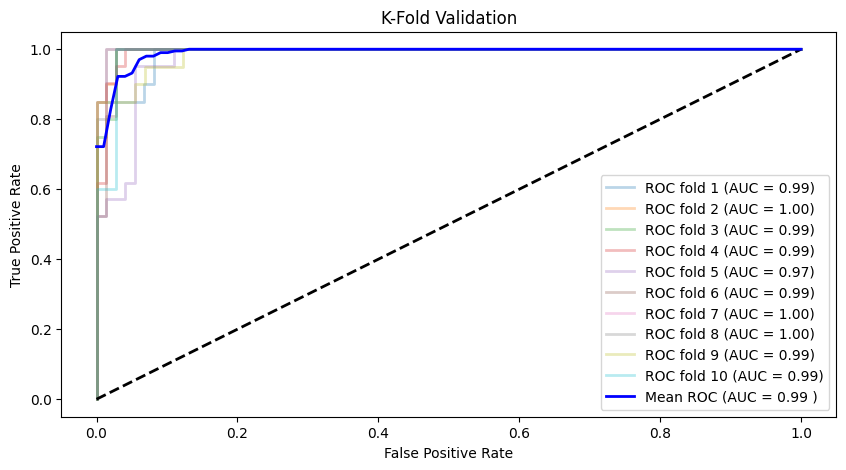

In [ ]:
# Строим семейство ROC  кривых
cv = model_selection.StratifiedKFold(n_splits=10, shuffle=True)
tprs, aucs = [], []
mean_fpr = np.linspace(0,1,100)
fig = plt.figure(figsize=(10,5),dpi=100)
i = 1
for train, test in cv.split(X_train, y_train):
    X_train_selected = X_train.iloc[train]

    y_train_selected = y_train.iloc[train]
    X_train_selected_test = X_train.iloc[test]
    y_train_selected_test = y_train.iloc[test]

    prediction = model.fit(X_train_selected, y_train_selected).predict_proba(X_train_selected_test)
    fpr, tpr, t = metrics.roc_curve(y_train_selected_test, prediction[:, 1], pos_label=1)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i = i+1
# Результат
plt.plot([0,1], [0,1], linestyle='--', lw=2, color='black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = metrics.auc(mean_fpr, mean_tpr)
# Выведем ROC кривые
plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K-Fold Validation')
plt.legend(loc="lower right")

plt.show()

AUC варьируется от 0.97 до 1.00 по разным фолдам.
Минимальное значение (fold 5) = 0.97.
Максимальное значение (folds 2, 7, 8) = 1.00.
Очень малый разброс значений (всего 0.03) указывает на высокую стабильность модели.

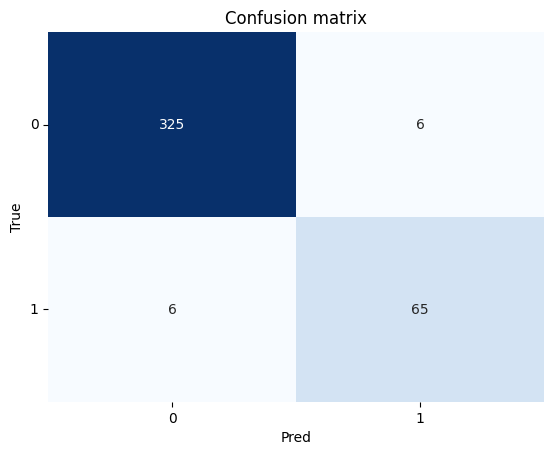

In [ ]:
'''
Confusion matrix (Мультиклассовый)
'''

classes = np.unique(y_test)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(y_test, predicted, labels=classes)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
ax.set_yticklabels(labels=classes, rotation=0)
'''
Построим график
'''
plt.show()

In [ ]:
'''
Вспомогательная функция для построения confusion matrix для каждого класса
'''
def compute_class(ls_res, class_value): # возвращаем строку имен классов
    y_t_class = ls_res.copy().astype(int)
    y_t_class = y_t_class.apply(lambda c: 1 if c  == class_value  else 0)
    return  y_t_class

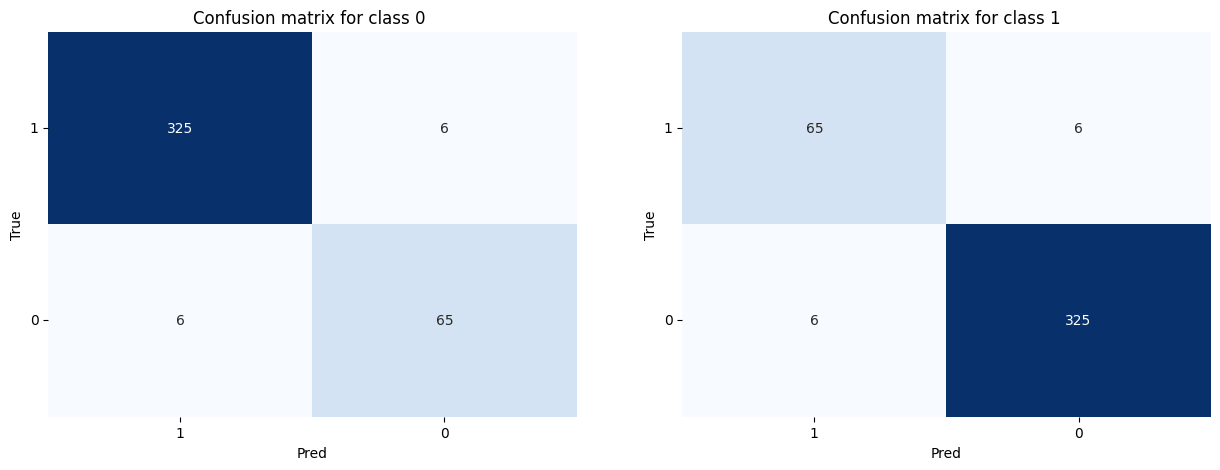

In [ ]:
'''
Confusion matrix (для каждого класса по отдельности)
'''

classes = np.unique(y_test).astype(int)
lbs = [1,0]
'''
plt.subplots()это функция, которая возвращает кортеж, содержащий фигуру и объект(ы) осей.
plt.subplots() возвращает кортеж с двумя элементами.
1-й должен быть объектом фигуры, а 2й должен быть группой объектов второстепенных сюжетов.

При использовании fig, ax = plt.subplots()вы распаковываете этот кортеж в переменные figи ,ax.

Наличие fig полезно, если вы хотите изменить атрибуты уровня фигуры или сохранить фигуру как файл изображения позже
(например, с помощью fig.savefig('yourfilename.png')).
plt.grid - Настройка линий сетки.

'''
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5), dpi=100)

for class_i in classes:
    y_one_class = compute_class(y_test,class_i)
    predicted_one_class = compute_class(pd.Series(predicted.tolist()),class_i)#возвращает строку имен классов
    cm = metrics.confusion_matrix(y_one_class, predicted_one_class, labels=lbs)
    sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False, ax=ax[class_i])
    ax[class_i].set(xlabel="Pred", ylabel="True", title=f"Confusion matrix for class {class_i} ")
    ax[class_i].set_xticklabels(labels=lbs, rotation=0)
    ax[class_i].set_yticklabels(labels=lbs, rotation=0)

'''
построим график

'''
plt.show()

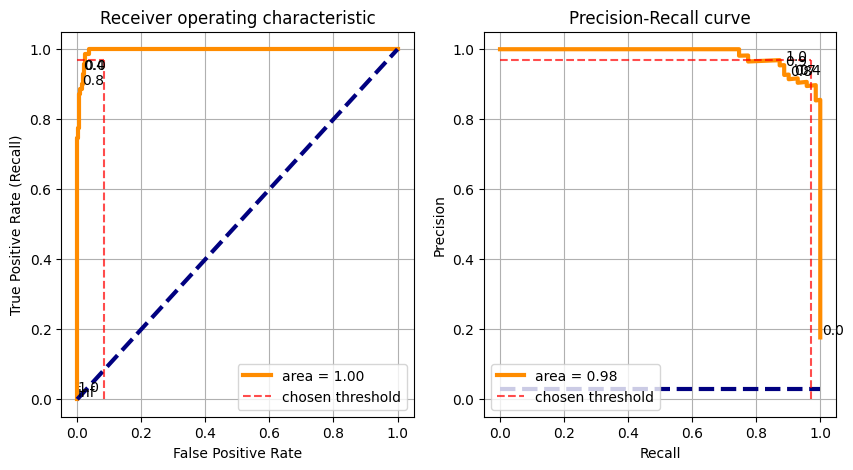

In [ ]:
'''
Еще ROC кривые
'''

classes = np.unique(y_test)
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,5),dpi=100)
'''

## plot ROC curve
построим кривую ROC

'''
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted_prob[:, 1], pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
ax[0].plot(fpr, tpr, color='darkorange', lw=3, label='area = %0.2f' % roc_auc)
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].hlines(y=recall, xmin=0, xmax=1-cm[0,0]/(cm[0,0]+cm[0,1]), color='red', linestyle='--', alpha=0.7, label="chosen threshold")
ax[0].vlines(x=1-cm[0,0]/(cm[0,0]+cm[0,1]), ymin=0, ymax=recall, color='red', linestyle='--', alpha=0.7)
ax[0].set(xlabel='False Positive Rate', ylabel="True Positive Rate (Recall)", title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
## annotate ROC thresholds
'''
найдем пороговые значения ROC
'''

thres_in_plot = []
for i,t in enumerate(thresholds):
    t = np.round(t,1)
    if t not in thres_in_plot:
        ax[0].annotate(t, xy=(fpr[i],tpr[i]), xytext=(fpr[i],tpr[i]),
                    textcoords='offset points', ha='left', va='bottom')
        thres_in_plot.append(t)
    else:
        next
## plot P-R curve
'''
плстроим привую P-R
'''

precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, predicted_prob[:,1], pos_label=1)
roc_auc = metrics.auc(recalls, precisions)
ax[1].plot(recalls, precisions, color='darkorange', lw=3, label='area = %0.2f' % roc_auc)
ax[1].plot([0,1], [(cm[1,0]+cm[1,0])/len(y_test), (cm[1,0]+cm[1,0])/len(y_test)], linestyle='--', color='navy', lw=3)
ax[1].hlines(y=precision, xmin=0, xmax=recall, color='red', linestyle='--', alpha=0.7, label="chosen threshold")
ax[1].vlines(x=recall, ymin=0, ymax=precision, color='red', linestyle='--', alpha=0.7)
ax[1].set(xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="lower left")
ax[1].grid(True)
## annotate P-R thresholds
'''
пороговые значения P-R
'''
thres_in_plot = []
for i,t in enumerate(thresholds):
    t = np.round(t,1)
    if t not in thres_in_plot:
        ax[1].annotate(np.round(t,1), xy=(recalls[i],precisions[i]),
                    xytext=(recalls[i],precisions[i]),
                    textcoords='offset points', ha='left', va='bottom')
        thres_in_plot.append(t)
    else:
        next
plt.show()

ROC-кривая (Receiver Operating Characteristic):
Area Under Curve (AUC) = 1.00 (идеальное значение).
Кривая проходит через точку (0,1) - признак идеального классификатора.
Precision-Recall кривая: Area Under Curve = 0.98 (очень высокое значение).
Кривая держится близко к значению 1.0 на большей части графика.
Резкое падение precision только при очень высоких значениях recall.
Практически идеальная классификация.
Минимальное количество ложных срабатываний.

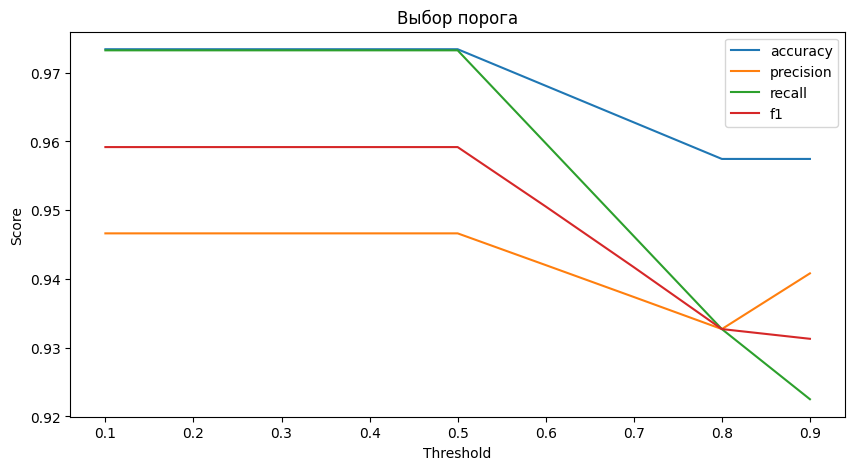

In [ ]:
# Построим графики значений отсечки для каждой метрики
# Значения метрик для различных пороговых значений вхождения в класс
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,5),dpi=100)

dic_scores = {'accuracy':[], 'precision':[], 'recall':[], 'f1':[]}
XX_train, XX_test, yy_train, yy_test = model_selection.train_test_split(X_train, y_train, test_size=0.2)
predicted_prob = model.fit(XX_train, yy_train).predict_proba(XX_test)[:,1]
thresholds = []
for threshold in np.arange(0.1, 1, step=0.1):
    predicted = (predicted_prob > threshold)
    thresholds.append(threshold)
    dic_scores["accuracy"].append(metrics.accuracy_score(yy_test, predicted))
    dic_scores["precision"].append(metrics.precision_score(yy_test, predicted, average='macro', zero_division=1))
    dic_scores["recall"].append(metrics.recall_score(yy_test, predicted, average='macro'))
    dic_scores["f1"].append(metrics.f1_score(yy_test, predicted, average='macro'))

# Строим графики
dtf_scores = pd.DataFrame(dic_scores).set_index(pd.Index(thresholds))
ax.set(xlabel='Threshold', ylabel="Score", title="Выбор порога")
dtf_scores.plot(ax=ax)

plt.show()

Модель показывает хорошую производительность.
Все метрики выше 0.92 даже при неоптимальных порогах.